In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import chi2
import cython
%load_ext Cython


from KalmanFilter import KalmanFilter as KFPedro
from KF_py import KalmanFilter as KF
from KF_py2 import KalmanFilter as KF2
from KalmanFilter_Uni import KalmanFilter as KFU
from KalmanFilter_UniCy import KalmanFilter as KFUC

%load_ext autotime
%load_ext snakeviz

# Bayesian Econometrics - Final Paper

Paper to be delivered as the course's final paper

Pedro Montero Mattos

MPE - Econometria

\#333791

# The Model - Local Level with Seasonal Component

As described in the chapter 4 in Koopman et al. The local level model with a seasonal component consists of the following equations:

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = -\gamma_{t} - \gamma_{t-1} - \theta_1\gamma_{t-2} + \omega_t \sim NID(0,\sigma^2_\omega) $$


We added a $\theta$ coefficient in order to use maximum likelihood estimation

## State Space Form

General Form:

$$ y_t = Z x_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$
$$ x_{t+1} = T x_t + R_t \eta_T, \qquad \eta_t \sim NID(0,Qt) $$

In terms of the model:
$$ 
x_t = 
\begin{pmatrix}\mu_t \\ \gamma_t  \\  \gamma_{t-1}   \\ \gamma_{t-2}  \end{pmatrix}
$$

$$
\eta_t = 
\begin{pmatrix}\xi_t \\ \omega_t \end{pmatrix}
$$

$$
T_t = 
\begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & -1 & -1 & -\theta_1 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 
\end{bmatrix}
$$



$$
Z^T_t = 
\begin{pmatrix}1 \\ 1  \\  0   \\ 0  \end{pmatrix}
$$

$$
Q_t = 
\begin{bmatrix} 
\sigma^2_\xi & 0 \\
0 & \sigma^2_\omega \\
\end{bmatrix}
$$

$$
R_t = 
\begin{bmatrix} 
1 & 0  \\
0 & 1  \\
0 & 0  \\
0 & 0  \\
\end{bmatrix}
$$

$$
H_t = 
\begin{bmatrix} 
\sigma^2_\epsilon
\end{bmatrix}
$$

# Generating the data for $\theta_1=0.7$

We have to choose all parameter values plus the initial states

$$\gamma_t = \gamma_{t-1} = \gamma_{t-2} = 0$$
$$\theta_1 = 0.7$$
$$\sigma^2_\xi = 0.1$$
$$\sigma^2_\omega = 0.2$$
$$\sigma^2_\epsilon = 0.3$$




In [2]:
n = 150
theta1 = 0.7
sigmaXi = 0.1
sigmaOmega = 0.2
sigmaEpsilon = 0.3

time: 3.15 ms


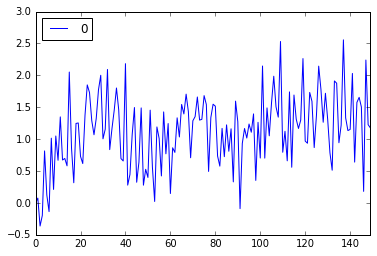

time: 410 ms


In [3]:
y = np.array([0])
mi = np.array([0])
gamma = np.array([0])

xi = np.array([0])
omega = np.array([0])
ep = np.array([0])

for i in range(1,n):

    # Level equation
    xi = np.append(xi,np.random.normal(scale=sigmaXi))
    mi = np.append(mi,mi[i-1]+xi[i])
    
    # Seasonality equation
    omega = np.append(omega,np.random.normal(scale=sigmaOmega))
    holder = 0
    if i-1 >= 0:
        holder -= gamma[i-1] 
    if i-2 >= 0:
        holder -= gamma[i-2] 
    if i-3 >= 0:
        holder -= gamma[i-3] * theta1
    
    gamma = np.append(gamma,holder+omega[i])
    
    # Series equation
    ep = np.append(ep,np.random.normal(scale=sigmaEpsilon))
    y = np.append(y,mi[i]+gamma[i]+ep[i])

y = pd.DataFrame(y) 
mi = pd.DataFrame(mi) 
gamma = pd.DataFrame(gamma) 

y.plot()

# Maximum Likelihood Estimates

Define a wrapper function that maps the theta vector of parameters to the state space matrices

$$\theta = [\theta_1, \sigma^2_\epsilon, \sigma^2_\xi, \sigma^2_\omega]'$$

The functions return the negative of the likelihood because the scipy optimization algorithms only minimize functions. Also we use the logarithm for numerical reasons.

In [4]:
def wrapper(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta[0]],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([theta[1]])

    Q = pd.DataFrame([
        [theta[2],0],
        [0,theta[3]],
    ])

    kf = KF(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return -np.log(kf['ll']*10e6)

time: 17.8 ms


## Define the additional state space matrices

In [5]:
Z = pd.DataFrame([
        [1,1,0,0],
    ])

R = pd.DataFrame([
        [1,0],
        [0,1],
        [0,0],
        [0,0],
    ])

time: 10.7 ms


Minimize the wrapper function, with the following initial values for $\theta$:

$$\theta = [0.5, 1, 1, 1]'$$
    

In [6]:
initialTheta = np.array([0.5,1.0,1.0,1.0])

time: 1.86 ms


In [ ]:
minimize(wrapper,initialTheta, 
         options={'disp':True, 'maxiter':1000}, 
#          bounds = ((-5,5),(None,None),(None,None),(None,None),), 
         method='SLSQP',
         )

In [ ]:
minimize(wrapper,initialTheta, 
         options={'disp':True, 'maxiter':500}, 
#          bounds = ((-5,5),(None,None),(None,None),(None,None),), 
         method='Powell',
         )

In [ ]:
minimize(wrapper,initialTheta, 
         options={'disp':True, 'maxiter':500}, 
#          bounds = ((-5,5),(None,None),(None,None),(None,None),), 
         method='BFGS',
         )

In [ ]:
minimize(wrapper,initialTheta, 
         options={'disp':True, 'maxiter':500}, 
#          bounds = ((-5,5),(None,None),(None,None),(None,None),), 
         method='Nelder-Mead',
         )

# Bayesian Estimates

## Wrapper, Priors and Posteriors

We chose to use the following priors:

$$\theta_1 \sim N(0,1)$$
$$\sigma^2_\epsilon \sim \chi_2(1)$$
$$\sigma^2_\xi \sim \chi_2(1)$$
$$\sigma^2_\omega \sim \chi_2(1)$$

In [34]:
def posterior(theta,priorMeans, priorVariances):
    
    i=0
    temp = norm.pdf(theta[i],priorMeans[i],priorVariances[i])
    for i in range(1,3+1):
        temp *= chi2.pdf(theta[i],1)
    
    ll = wrapper(theta)
#     print(ll)
    return ll * temp

time: 8.38 ms


In [35]:
def wrapper(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta[0]],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([theta[1]])

    Q = pd.DataFrame([
        [theta[2],0],
        [0,theta[3]],
    ])

    kf = KFUC(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return kf

time: 15.9 ms


## MCMC - Metropolis Hastings

We chose to use a random walk metropolis hastings of the form

---
**Metropolis-Hastings Algoritm**

Guess $\theta^{(0)}$ and for $i=0$ until $n$: 
1. $\theta=\theta^{(i-1)} + \eta_t$ where $\eta_t \sim N(0,\sigma)$
2. Compute $r=\min(1,\alpha)$ where $\alpha= \frac{p(\theta')q(\theta|\theta')}{p(\theta)q(\theta'|\theta)}$
4. Draw $u\sim U(0,1)$
5. $\theta^{(i+1)}=\begin{cases}\theta' & \text{if $u<r$}\\\theta & \text{if $u\geq r$}\end{cases}$

---

We use the logarithmic transformations for all variance parameters

In [36]:
def randomWalkMH(sample,burn, initialTheta, randomWalkSigmas,priorMeans,priorVariances):

    thetaMH = []
    accept = np.zeros([sample])
    posts = np.zeros([sample])

    thetaMH.append(initialTheta)

    thetastemps = []
    disturbances = []

    for i in range(1,sample):
        disturbance = np.multiply(np.random.randn(thetaMH[0].shape[0]),randomWalkSigmas)
    #     disturbance[1:] = np.exp(disturbance[1:]) #problema está aqui
    #     print(disturbance)
        thetaTemp = thetaMH[i-1].copy()
        thetaTemp[1:] = np.log(thetaMH[i-1][1:])+disturbance[1:]
        thetaTemp[1:] = np.exp(thetaTemp[1:])
        thetaTemp[0] = thetaTemp[0] + disturbance[0]
        disturbances.append(disturbance)
        thetastemps.append(thetaTemp.copy())
    #     print(thetaTemp)
    #     print(thetastemps[i-1])
    #     thetaTemp = (temp)
        tempPost = posterior(thetaTemp,priorMeans, priorVariances)
        lalpha = np.log(tempPost) - np.log(posts[i-1])
        r = np.min([1, np.exp(lalpha)])

        u = np.random.uniform()

        if u < r:
            accept[i] = 1
            thetaMH.append(thetaTemp)
            posts[i] = tempPost
        else:
            thetaMH.append(thetaMH[i-1])
            posts[i] = posts[i-1]    

    post = pd.DataFrame(thetaMH)
    return {'posterior' : post[burn:], 'accept' : accept}

time: 37.4 ms


In [40]:
sample = 5000

sigma = 0.3
randomWalkSigmas = np.array([0.1,sigma,sigma,sigma])

priorMeans = np.array([0,0,0,0])

priorVariances = 3 * np.ones(4)

mcmc = randomWalkMH(sample = sample,
                 burn = 500, 
                 initialTheta = initialTheta, 
                 randomWalkSigmas = randomWalkSigmas,
                 priorMeans = priorMeans,
                 priorVariances = priorVariances)

/Users/mac/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log


time: 1min 4s


**Acceptance Ratio**

In [41]:
mcmc['accept'].sum() / mcmc['accept'].shape[0]

0.26679999999999998

time: 3.77 ms


## Marginal distribution for $\theta_1$

True value is $0.7$

In [42]:
par = 0

time: 827 µs


In [43]:
mcmc['posterior'][par].describe()

count    4500.000000
mean        0.644512
std         0.056673
min         0.433298
25%         0.607049
50%         0.644263
75%         0.683679
max         0.828067
Name: 0, dtype: float64

time: 8.91 ms


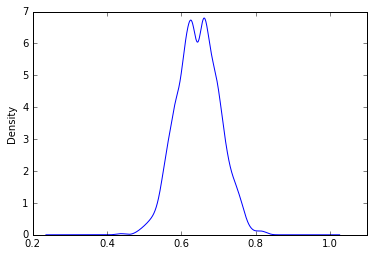

time: 445 ms


In [44]:
mcmc['posterior'][par].plot.density()

## Marginal distribution for $\sigma^2_\epsilon$

True value is $0.3$

In [47]:
par = 1

time: 1.22 ms


In [48]:
mcmc['posterior'][par].describe()

count    4.500000e+03
mean     1.247505e-04
std      8.003728e-04
min      5.038152e-14
25%      4.797352e-12
50%      1.245064e-08
75%      1.976503e-07
max      1.161997e-02
Name: 1, dtype: float64

time: 10.2 ms


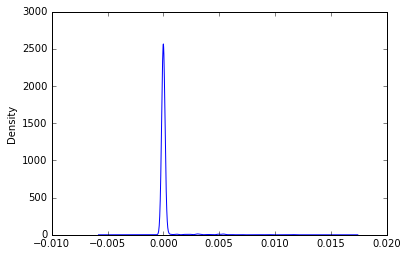

time: 492 ms


In [49]:
mcmc['posterior'][par].plot.density()

## Marginal distribution for $\sigma^2_\xi$

True value is $0.1$

In [50]:
par = 2

time: 1.35 ms


In [51]:
mcmc['posterior'][par].describe()

count    4500.000000
mean        0.035803
std         0.009673
min         0.016112
25%         0.028996
50%         0.034700
75%         0.041036
max         0.080027
Name: 2, dtype: float64

time: 10.3 ms


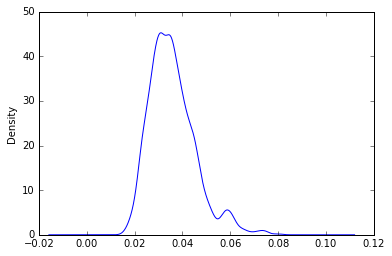

time: 442 ms


In [52]:
mcmc['posterior'][par].plot.density()

## Marginal distribution for $\sigma^2_\omega$

True value is $0.2$

In [53]:
par = 3

time: 829 µs


In [54]:
mcmc['posterior'][par].describe()

count    4500.000000
mean        0.074072
std         0.013683
min         0.036514
25%         0.063909
50%         0.072931
75%         0.083103
max         0.135179
Name: 3, dtype: float64

time: 9.95 ms


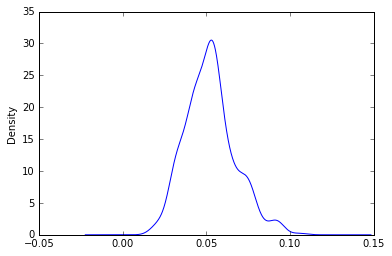

time: 344 ms


In [25]:
mcmc['posterior'][par].plot.density()

# Performance Optimization

## Profiling the Kalman Filter

Profiling should always be the first step on every optimization

We'll profile the KF with the true values

In [26]:
def KF_func(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-0.7],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([0.3])

    Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])

    kf = KF(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return kf['ll']


time: 16.6 ms


In [27]:
%%snakeviz

KF_func(0)

 
*** Profile stats marshalled to file '/var/folders/s0/cpch1n253877slkrcpdzqgph0000gn/T/tmp7jjf748e'. 
time: 3.09 s


The problem is that dot products and matrix inversions are already optimized in fortran and C

## Univariate Approach

Makes best use of cython

In [28]:
def KF_funcUni(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-0.7],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([0.3])

    Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])

    kf = KFU(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return kf



time: 16.8 ms


In [30]:
%%timeit
KF_func(0)

10 loops, best of 3: 27.8 ms per loop
time: 1.2 s


In [31]:
%%timeit
KF_funcUni(0)

100 loops, best of 3: 13.8 ms per loop
time: 5.78 s


In [46]:
%%snakeviz

KF_funcUni(0)

 
*** Profile stats marshalled to file '/var/folders/s0/cpch1n253877slkrcpdzqgph0000gn/T/tmpyt82mm5l'. 
time: 3.04 s


Since dot is already optimized we will move on to cython

In [29]:
def KF_funcUniC(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-0.7],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([0.3])

    Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])

    kf = KFUC(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return kf




time: 19.1 ms


In [32]:
%%timeit
KF_funcUniC(0)

100 loops, best of 3: 11.7 ms per loop
time: 4.99 s


Further ideas:

* Eliminate whole line assignments using loops (First check whether that's actually faster)